In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
PATH='/content/drive/My Drive/Universidad/Clases/Deep Learning/Proyecto'
os.chdir(PATH)
import sys
sys.path.append(PATH)
sys.path.append(os.path.join(PATH, 'Joaco'))

Mounted at /content/drive


In [ ]:
from utils import EarlyStopping, train_step, val_step
from Inception1d import Inception_CNN
import torch
import numpy as np
from torch.optim import Adam
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from torch.optim.lr_scheduler import CosineAnnealingLR

In [ ]:
#Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
#Anomaly detection for exploding gradients
torch.autograd.set_detect_anomaly(True)

In [ ]:
#Setup hyperparameters
hyper={'lr':1e-4, 'b1':.9, 'b2':.999,'patience':12,'min_change':0}

In [ ]:
#Charge initialized dataloaders for paper architecture (70 train,15 val, 15 test. Batch size 128 (115 batches) for training and 1 for validation and testing (3154 batches)).

train_dataloader=torch.load('Joaco/Project_Globally_Normalized_Dataloaders_2/train_normalized.pth') #Features normalizadas con media 35.1772884001906 y desviación estándar 23.37894035215964.
val_dataloader=torch.load('Joaco/Project_Globally_Normalized_Dataloaders_2/val_normalized.pth') #Labels normalizadas con media 0.003610669885808889 y desviación estándar 0.0063560217328015945.
test_dataloader=torch.load('Joaco/Project_Globally_Normalized_Dataloaders_2/test_not_normalized.pth') #Estos datos hay que normalizarlos antes de entrar a la red y escalar la salida de la red para poder comparar con labels no normalizadas.

train_feature_mean,train_feature_std= 35.1772884001906, 23.37894035215964 #variables for converting from raw data to normalize data and viceversa.
train_label_mean, train_label_std= 0.003610669885808889, 0.0063560217328015945

In [ ]:
model=Inception_CNN()
#Setup optimizer, learning rate scheduler and loss function.
optimizer=Adam(model.parameters(),lr=hyper['lr'],betas=(hyper['b1'],hyper['b2']), weight_decay=1e-5) #Weight_decay is equivalent to L2 regularization.
MAXIMUM_EPOCHS = 50 #By 50 epochs we should have reached a local minima.
scheduler=CosineAnnealingLR(optimizer,T_max=MAXIMUM_EPOCHS) #We set T_max as the maximum number of epochs so we don't do warm resets.
loss_fn=torch.nn.MSELoss() #MSELoss for regression task.

In [ ]:
MODELS_PATH=os.path.join(PATH,'Joaco/Models')
Trained_model_path=os.path.join(MODELS_PATH,'Trained_model_1.pth') #Location of to-be saved model.

#Setup early stopping
early_stopping=EarlyStopping(patience=hyper['patience'],delta=hyper['min_change']) #Initialize early stopping (a patience of only 12 because there's a maximum of 50 epochs)
#Run training loop
best_epoch=0 #Variables for keeping track of the best model's metrics
best_val_loss=0
train_loss_history,train_r2_history,val_loss_history,val_r2_history=[],[],[],[] #Initialize history trackers.
for epoch in tqdm(np.arange(MAXIMUM_EPOCHS)): #progress bar
    train_loss_epoch,train_r2_epoch=train_step(data_loader=train_dataloader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=r2_score,
        device=device)
    train_loss_history.append(train_loss_epoch) #add the train loss to the history
    train_r2_history.append(train_r2_epoch) #add the train r2 score to the history
    val_loss_epoch, val_r2_epoch =val_step(data_loader=val_dataloader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=r2_score,
        device=device)
    val_loss_history.append(val_loss_epoch) #add the val loss to the val loss history
    val_r2_history.append(val_r2_epoch) #add the val accuracy to the val accuracy history
    stop, is_best = early_stopping.count(metric=val_loss_epoch)
    if stop:
        print(f"Early stopping criterion achieved at epoch number {best_epoch} with a minimum validation loss of {best_val_loss}. Stopping the loop.") #Exit showing best metrics.
        break

    if is_best:
        if os.path.exists(Trained_model_path): #Make sure we only have one file called this way (torch.save should overwrite but it doesn't seem to be working like that)
          os.remove(Trained_model_path)
        torch.save(obj=model.state_dict(), #saving the state_dict() only saves the learned parameters
           f=Trained_model_path)
        best_epoch=epoch
        best_val_loss=val_loss_epoch

    scheduler.step() #Update scheduler after updating optimizer (done inside training function)

    if epoch%5==0: #Print metrics every 5 epochs
        print(f"Epoch: {epoch}\n-------------------------------------------------------------------")
        print(f"Train loss: {train_loss_epoch:.5f}| Train r2 score:{train_r2_epoch:.5f}")
        print(f"Validation loss: {val_loss_epoch:.5f}| Validation r2 score:{val_r2_epoch:.5f}")
        print("-------------------------------------------------------------------")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
-------------------------------------------------------------------
Train loss: 0.14343| Train r2 score:-3.21683
Validation loss: 0.09409| Validation r2 score:-0.38738
-------------------------------------------------------------------
Epoch: 5
-------------------------------------------------------------------
Train loss: 0.09092| Train r2 score:-0.88289
Validation loss: 0.07518| Validation r2 score:-1.96089
-------------------------------------------------------------------
Epoch: 10
-------------------------------------------------------------------
Train loss: 0.07550| Train r2 score:-0.35696
Validation loss: 0.06893| Validation r2 score:0.68035
-------------------------------------------------------------------
Epoch: 15
-------------------------------------------------------------------
Train loss: 0.06804| Train r2 score:-0.28284
Validation loss: 0.07578| Validation r2 score:0.67797
-------------------------------------------------------------------
Epoch: 20
----------

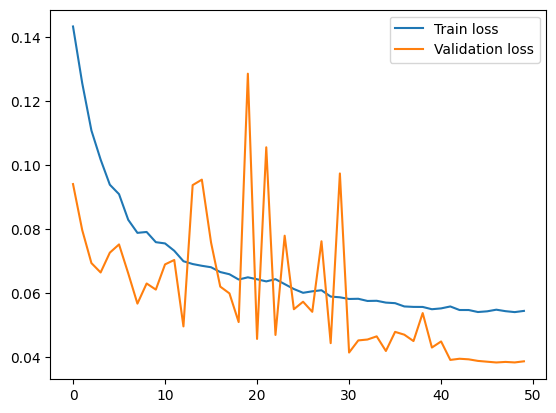

In [ ]:
plt.plot(train_loss_history,label='Train loss')
plt.plot(val_loss_history,label='Validation loss')
plt.legend()
plt.show()

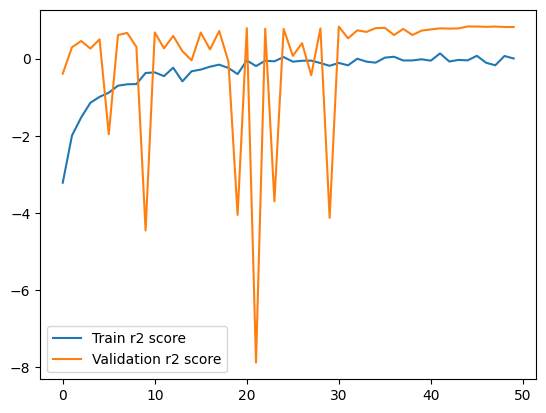

In [ ]:
plt.plot(train_r2_history,label='Train r2 score')
plt.plot(val_r2_history,label='Validation r2 score')
plt.legend()
plt.show()

In [ ]:
preds  = []
vals = []
model.load_state_dict(torch.load(Trained_model_path)) #Load the best model.
model.to(device)
model.eval()
with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs = inputs.to(device=device) #Inputs aren't normalized in the test dataloader.
        inputs= (inputs-train_feature_mean)/train_feature_std #Normalized test data (Only necessary if input data isn't already normalized, otherwise comment).
        targets = targets.to(device=device)

        outputs = model(inputs.unsqueeze(1))
        outputs=outputs*train_label_std+train_label_mean #Denormalize model outputs to match test scale (Only necessary if labels aren't normalized already, otherwise comment).
        preds.append(outputs.cpu().numpy()) #Add denormalized output to prediction list
        vals.append(targets.cpu().numpy()) #Add denormalized label to truth values list.

test_preds = np.concatenate(preds)
test_values = np.concatenate(vals)

In [ ]:
from sklearn.metrics import mean_absolute_error#, root_mean_squared_error
# Evaluar el modelo en el conjunto de validación
predictions = []
true_values = []

model.to(device)
model.eval()
with torch.no_grad():
  for inputs, targets in val_dataloader:
      inputs = inputs.to(device=device)
      targets = targets.to(device=device)

      outputs = model(inputs.unsqueeze(1))
      predictions.append(outputs.cpu().numpy())
      true_values.append(targets.cpu().numpy())

# Convertir listas a arrays
predictions = np.concatenate(predictions)
true_values = np.concatenate(true_values)

# Calcular las métricas
mae = mean_absolute_error(true_values, predictions)
#rmse = root_mean_squared_error(true_values, predictions)

print(f"Mean Absolute Error: {mae}")
#print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 0.10220444202423096


In [ ]:
pearson_corrs = []
r2_scores = []

for i in range(test_values.shape[0]):
    pearson_corr = np.corrcoef(test_values[i], test_preds[i])[0, 1]
    r2 = pearson_corr ** 2
    pearson_corrs.append(pearson_corr)
    r2_scores.append(r2)

global_r2 = np.mean(r2_scores)

print(f"Global R² test: {global_r2}")

pearson_corrs = []
r2_scores = []

for i in range(true_values.shape[0]):
    pearson_corr = np.corrcoef(true_values[i], predictions[i])[0, 1]
    r2 = pearson_corr ** 2
    pearson_corrs.append(pearson_corr)
    r2_scores.append(r2)

global_r2 = np.mean(r2_scores)

print(f"Global R² validation: {global_r2}")

Global R² test: 0.9210346703949119
Global R² validation: 0.9275577043932614


In [ ]:
best_val_loss, best_epoch

(0.038219755876617294, 46)

In [ ]:
preds  = []
vals = []
model.load_state_dict(torch.load(Trained_model_path)) #Load the best model.
model.to(device)
model.eval()
with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs = inputs.to(device=device) #Inputs aren't normalized in the test dataloader.
        #inputs= (inputs-train_feature_mean)/train_feature_std #Normalized test data (Only necessary if input data isn't already normalized, otherwise comment).
        targets = targets.to(device=device)

        outputs = model(inputs.unsqueeze(1))
        outputs=outputs*train_label_std+train_label_mean #Denormalize model outputs to match test scale (Only necessary if labels aren't normalized already, otherwise comment).
        preds.append(outputs.cpu().numpy()) #Add denormalized output to prediction list
        vals.append(targets.cpu().numpy()) #Add denormalized label to truth values list.

test_preds_not_normalized = np.concatenate(preds)
test_values_not_normalized = np.concatenate(vals)

In [ ]:
pearson_corrs = []
r2_scores = []

for i in range(test_values.shape[0]):
    pearson_corr = np.corrcoef(test_values[i], test_preds[i])[0, 1]
    r2 = pearson_corr ** 2
    pearson_corrs.append(pearson_corr)
    r2_scores.append(r2)

global_r2 = np.mean(r2_scores)

print(f"Global R² test: {global_r2}")

Global R² test: 0.8443482675915198


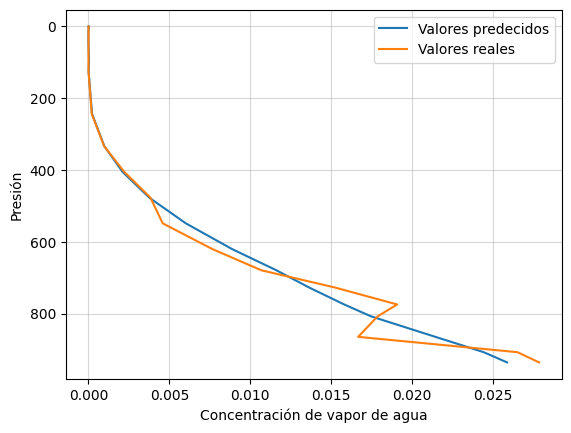

In [ ]:
presiones = [1.5949503422e-01, 6.1677907944e-01, 2.6202105713e+00, 1.3643401489e+01, 4.0175408936e+01, 9.2365717773e+01, 1.2783702637e+02, 2.4388471558e+02, 3.3348357666e+02, 4.0541115967e+02, 4.7708076416e+02, 5.4860190674e+02, 6.1999756836e+02, 6.7943752563e+02, 7.2699364502e+02, 7.7449785034e+02, 8.0775010010e+02, 8.6473732971e+02, 9.0746744019e+02, 9.3596556274e+02]
plt.plot(test_preds[0], presiones, label='Valores predecidos')
plt.plot(test_values[0], presiones, label='Valores reales')

plt.xlabel('Concentración de vapor de agua')
plt.ylabel('Presión')
plt.grid(True, alpha=0.5)
plt.gca().invert_yaxis()
plt.legend()
plt.show()

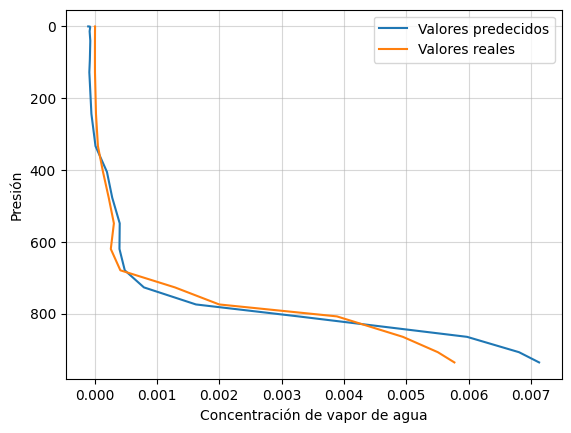

In [ ]:
plt.plot(test_preds[15], presiones, label='Valores predecidos')
plt.plot(test_values[15], presiones, label='Valores reales')

plt.xlabel('Concentración de vapor de agua')
plt.ylabel('Presión')
plt.grid(True, alpha=0.5)
plt.gca().invert_yaxis()
plt.legend()
plt.show()

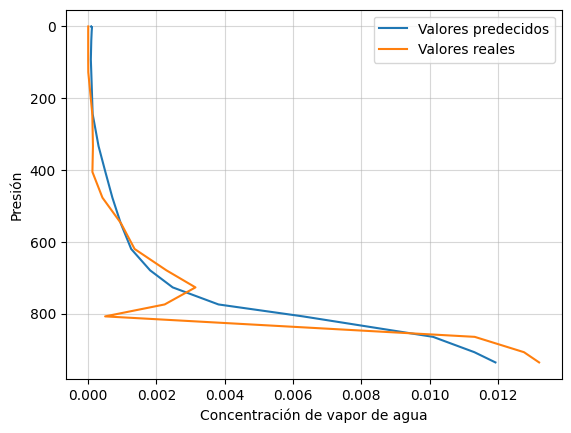

In [ ]:
plt.plot(test_preds[2002], presiones, label='Valores predecidos')
plt.plot(test_values[2002], presiones, label='Valores reales')

plt.xlabel('Concentración de vapor de agua')
plt.ylabel('Presión')
plt.grid(True, alpha=0.5)
plt.gca().invert_yaxis()
plt.legend()
plt.show()